<center><img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<H1 align='center'> DESAFÍO TAREA 1</H1>

<H3 align='center'> INF395 2023-2 </H3>
<hr style="height:2px;border:none"/>

## Integrantes:
* Joaquín Aguirre (201910031-9)
* Alejandro Villazón (201910009-2)
* Dominique Yessouroun (201910005-K)

Importamos las librerías necesarias:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif


import os
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

from sklearn.neighbors import NearestNeighbors

import warnings

# Ignorar las advertencias
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Helper functions

In [2]:
def rellenar(train, modificar, k=5, ponderado = False):
    '''
    Rellenamos columna por columna los datos faltantes con el valor del promedio
    de los 'k' vecinos más cercanos no nulos según latitud 'la' y longitud 'long',
    Si ponderado = True se asigna más peso a las observaciones más cercanas según 1/distancia,
    salvo si hay una distancia = 0, en ese caso se asigna el valor de esa observación.
    Si ponderado = False, se calcula el promedio clásico de los valores.
    '''
    mod = modificar.copy()
    for columna in mod.columns[mod.isna().any()]:
        aux = train.copy().dropna(subset=[columna]).reset_index(drop=True)
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(aux[["lat","long"]])
        for id_x,fila in mod[mod[columna].isna()].iterrows(): 
            distances, indices = nbrs.kneighbors(fila[["lat","long"]].values.reshape(1, 2))
            if ponderado:
                if distances[0][0] == 0:
                    mod.loc[id_x,columna] = aux.loc[indices[0], columna].values[0]
                else:
                    mod.loc[id_x,columna] = np.dot(aux.loc[indices[0], columna].values, 1/distances[0]) / np.sum(1/distances[0])
            else:
                mod.loc[id_x,columna] = aux.loc[indices[0], columna].mean()
    return mod


In [3]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [4]:
def plot_losses(history, loss, title = 'Error Graph'):
    "Función para graficar la función de pérdida del modelo"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel(loss.name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Descargamos los datos:

In [5]:
df = pd.read_csv('/kaggle/input/inf-395-tarea-1/data_kaggle/data/train_data.csv', index_col="ID")
x_test = pd.read_csv('/kaggle/input/inf-395-tarea-1/data_kaggle/data/test_data.csv',index_col="ID")

Exploremos los datos:

In [7]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

df_info = datainfo(df)
df_info

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
date,object,1276,280,0,0.000000
zipcode,int64,1276,66,0,0.000000
lat,float64,1276,1000,0,0.000000
long,float64,1276,408,0,0.000000
bedrooms,float64,1074,10,202,15.830721
bathrooms,float64,1079,22,197,15.438871
sqft_living,float64,1082,366,194,15.203762
sqft_lot,float64,1087,870,189,14.811912
floors,float64,1084,5,192,15.047022
waterfront,float64,1076,2,200,15.673981


Observamos que todas las variables son numéricas, salvo la fecha, que es tipo object (generalización de str). Además, notamos que tenemos presencia de datos faltantes.

In [8]:
df_info.query('NaN_Values > 0')[['NaN_Values']]

,NaN_Values
bedrooms,202
bathrooms,197
sqft_living,194
sqft_lot,189
floors,192
waterfront,200
view,194
condition,181
grade,190
sqft_above,187


In [9]:
df_info.query('NaN_Values > 0')[['NaN_Values_Percentage']]

,NaN_Values_Percentage
bedrooms,15.830721
bathrooms,15.438871
sqft_living,15.203762
sqft_lot,14.811912
floors,15.047022
waterfront,15.673981
view,15.203762
condition,14.184953
grade,14.890282
sqft_above,14.655172


Se tiene un problema grave de datos faltantes debido a que en varias variables se tiene que alrededor del 15% toma valor nulo. Más adelante en el notebook se abordará este problema.

# Exploración de features

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,1276.0,98076.235110,54.734005,98001.0000,98029.000,98059.0000,98117.00000,9.819900e+04
lat,1276.0,47.567730,0.137067,47.1622,47.492,47.5882,47.68130,4.777750e+01
long,1276.0,-122.207464,0.147224,-122.5110,-122.339,-122.2150,-122.10975,-1.214020e+02
bedrooms,1074.0,3.388268,0.937513,1.0000,3.000,3.0000,4.00000,1.000000e+01
bathrooms,1079.0,2.148054,0.853977,0.0000,1.500,2.2500,2.50000,7.500000e+00
sqft_living,1082.0,2140.665434,977.118984,540.0000,1420.000,1990.0000,2620.00000,7.000000e+03
sqft_lot,1087.0,22913.940202,52877.670777,638.0000,5383.000,8145.0000,14578.50000,7.156900e+05
floors,1084.0,1.496771,0.534790,1.0000,1.000,1.5000,2.00000,3.000000e+00
waterfront,1076.0,0.011152,0.105063,0.0000,0.000,0.0000,0.00000,1.000000e+00
view,1082.0,0.252311,0.811640,0.0000,0.000,0.0000,0.00000,4.000000e+00


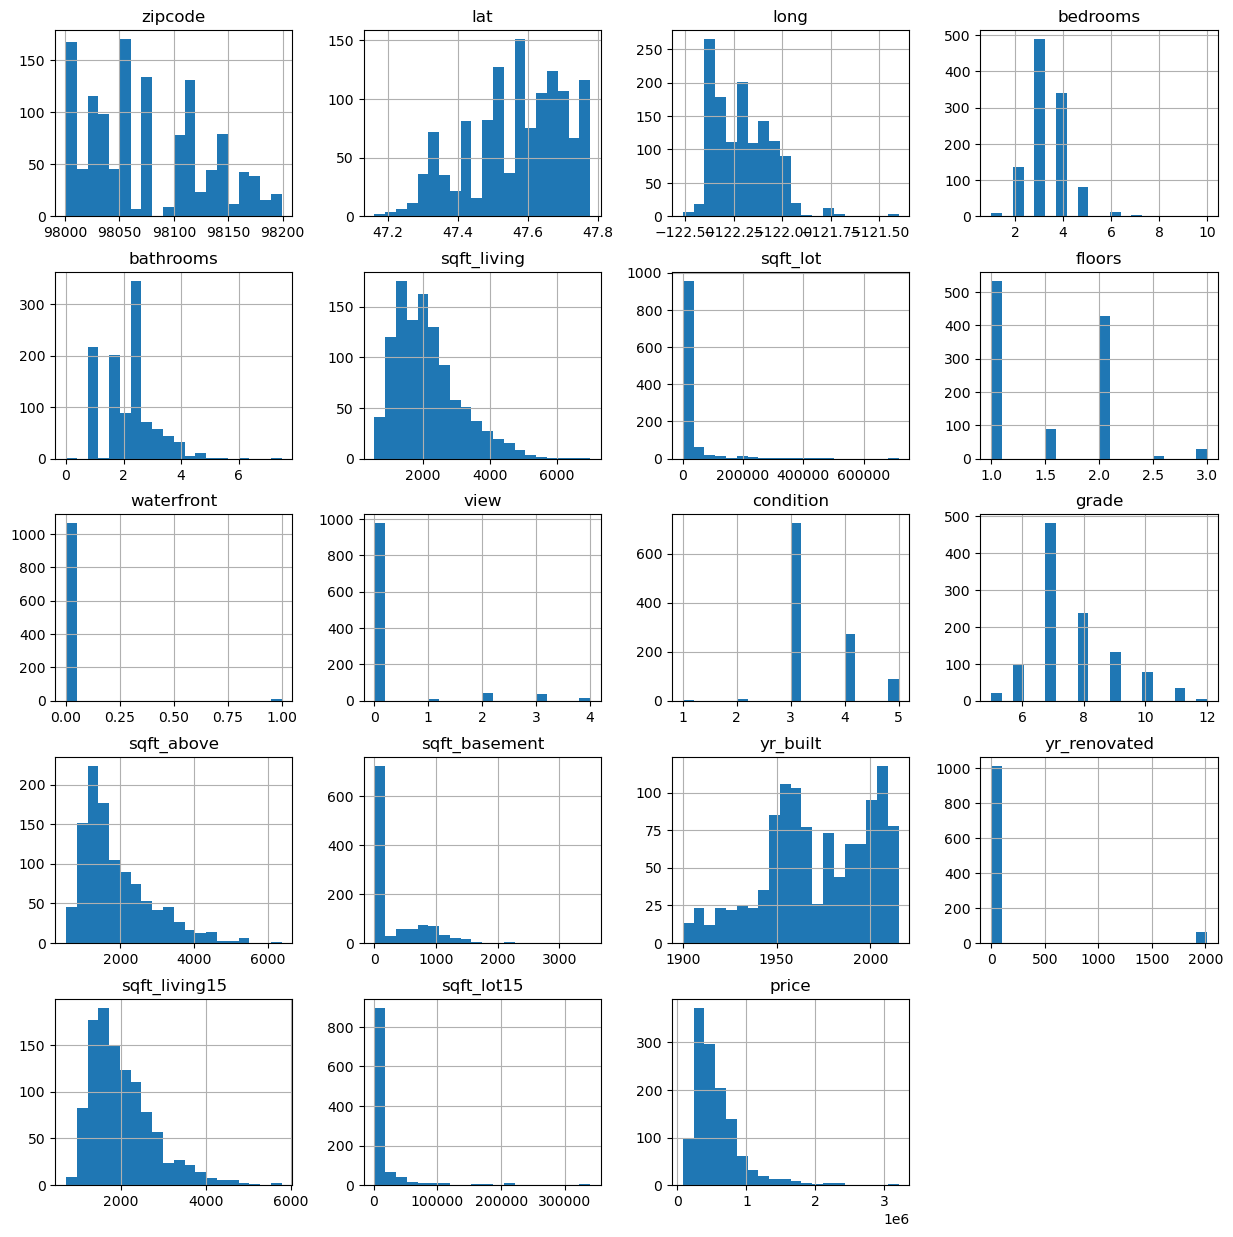

In [11]:
df.hist(figsize=(15,15), layout=(5,4), bins=20);

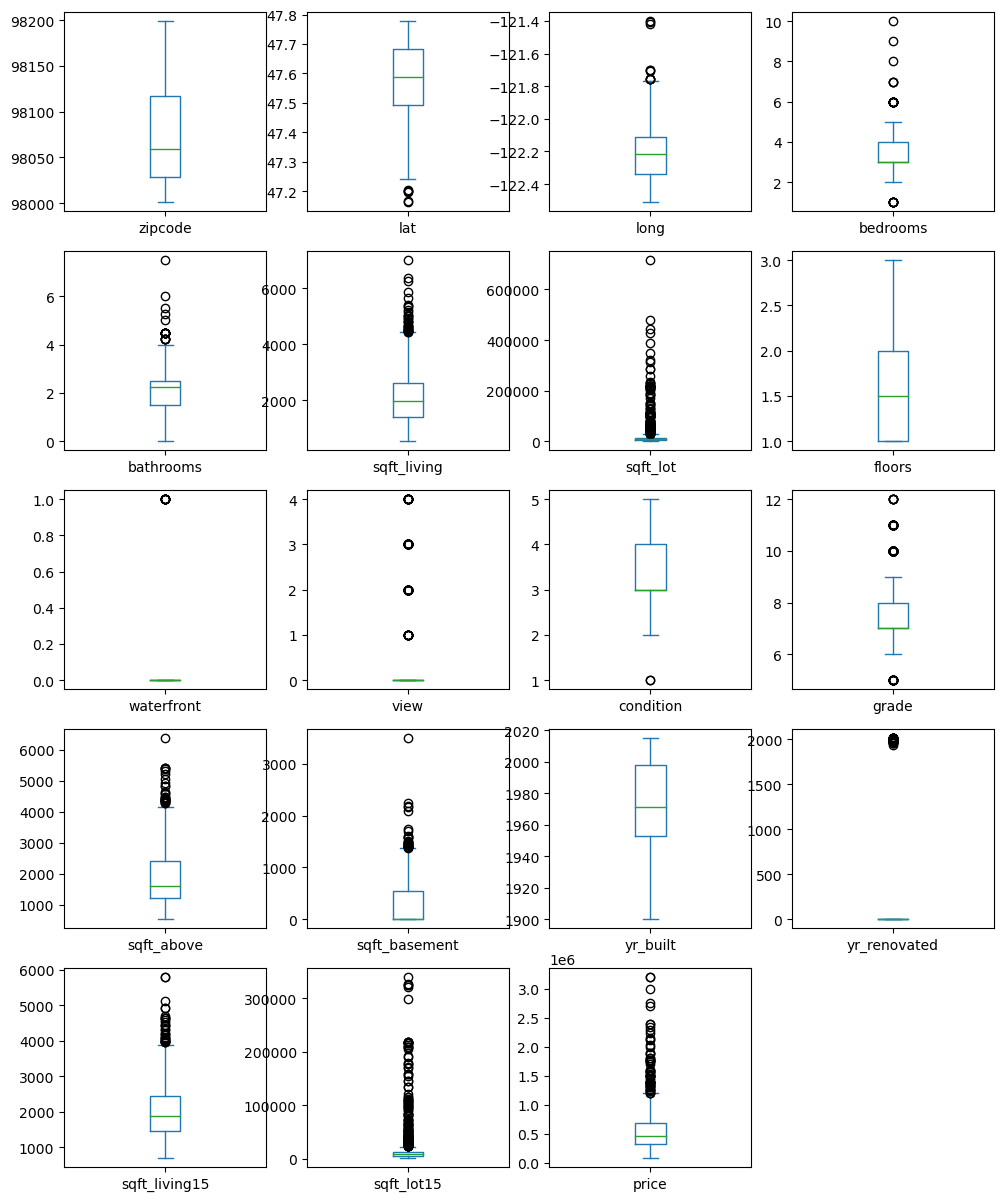

In [12]:
df.plot(kind="box",
        subplots=True,
        layout=(5,4),
        figsize=(12,15),
        );

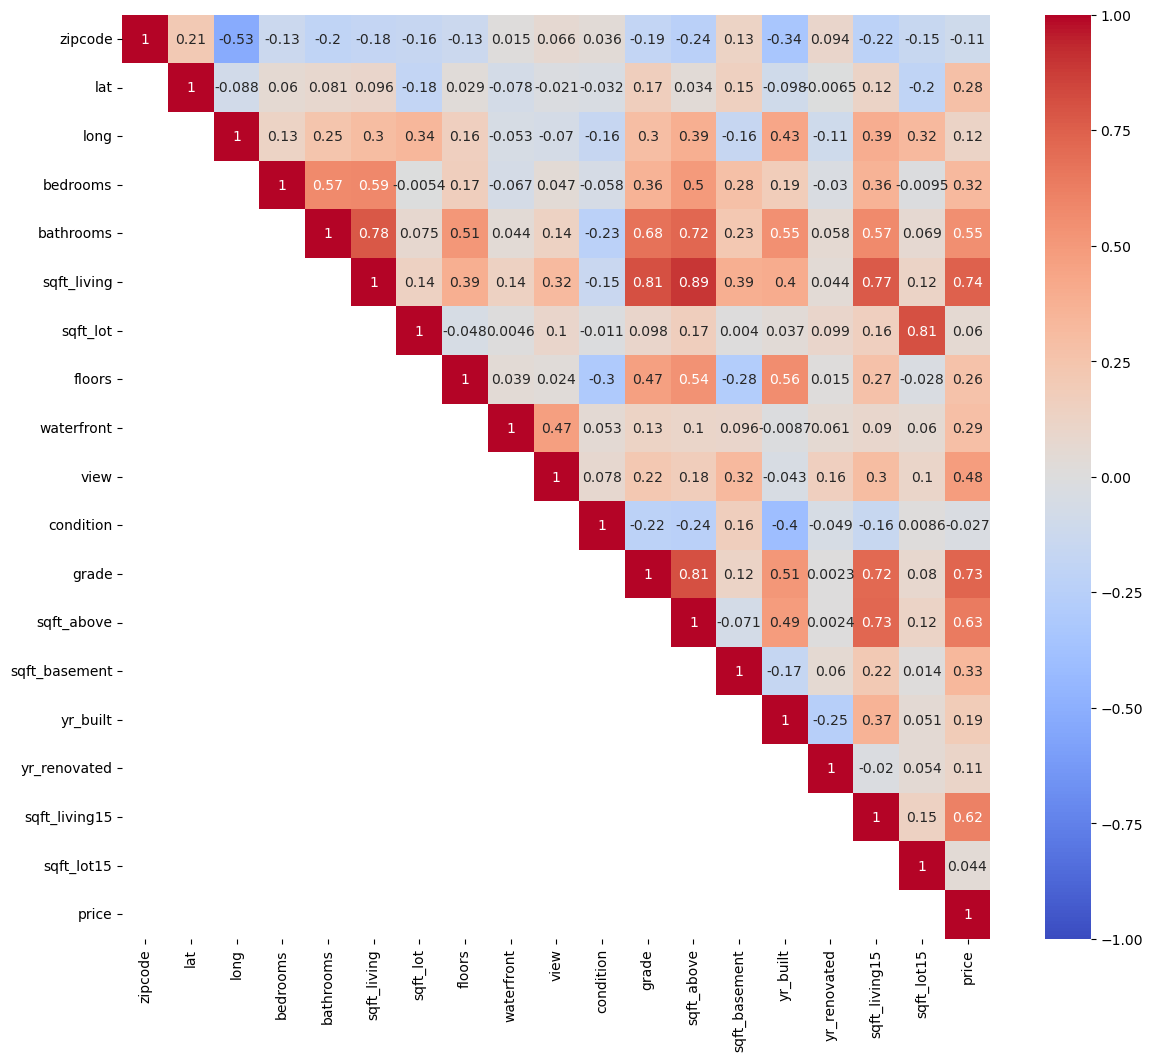

In [13]:
mask = np.tril(np.ones_like(df.corr(numeric_only=True), dtype=bool), k = -1)
plt.figure(figsize = (14,12))

sns.heatmap(df.corr(numeric_only=True), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', mask = mask);

## COMENTARIOS
---
---
---

# Feature Engineering

Transformaremos la variable `date` a año, mes, dia del año, asumiendo que son 365 días por año.

In [14]:
df[["date"]]

,date
ID,
143,20140515T000000
1175,20141203T000000
221,20140711T000000
1231,20141117T000000
509,20150402T000000
...,...
954,20150423T000000
104,20150507T000000
138,20140911T000000


In [15]:
df["date"] = pd.to_datetime(df["date"])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear
df = df.drop(columns=['date'])

df.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,year,month,day
ID,,,,,,,,,,,,,,,,,,,,,
143,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,...,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0,2014,5,135
1175,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,0.0,0.0,...,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0,2014,12,337
221,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,...,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0,2014,7,192
1231,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,0.0,0.0,...,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0,2014,11,321
509,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,0.0,NaN,...,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0,2015,4,92


Realizamos el mismo procedimiento al conjunto de prueba.

In [16]:
x_test["date"] = pd.to_datetime(x_test["date"])
x_test['year'] = x_test['date'].dt.year
x_test['month'] = x_test['date'].dt.month
x_test['day'] = x_test['date'].dt.dayofyear
x_test = x_test.drop(columns=['date'])

x_test.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,year,month,day
ID,,,,,,,,,,,,,,,,,,,,,
1473,98006,47.5544,-122.147,NaN,4.50,4490.0,24767.0,2.0,0.0,2.0,...,NaN,3800.0,690.0,1998.0,0.0,3370.0,32700.0,2015,4,111
716,98030,47.3573,-122.200,3.0,NaN,1730.0,6007.0,NaN,0.0,0.0,...,8.0,NaN,0.0,NaN,0.0,2000.0,6245.0,2014,10,302
1360,98074,47.6085,-122.013,4.0,2.50,3720.0,8633.0,2.0,0.0,0.0,...,10.0,3720.0,0.0,1999.0,NaN,3515.0,9660.0,2014,12,351
1522,98027,47.4913,-122.081,4.0,2.50,2550.0,NaN,2.0,0.0,0.0,...,9.0,2550.0,0.0,2001.0,0.0,1870.0,56628.0,2014,7,196
1570,98146,47.4982,-122.362,1.0,0.75,480.0,9750.0,1.0,0.0,0.0,...,4.0,480.0,0.0,1948.0,0.0,1550.0,9924.0,2014,8,237


Dada la periodicidad de las variables temporales, las transformamos a variables cíclicas con representación seno-coseno.

In [17]:
#Pasar los datos ciclicos a seno y coseno.

df = preprocess_time(df,"day",365)
df = preprocess_time(df,"month",12)
x_test = preprocess_time(x_test,"day",365)
x_test = preprocess_time(x_test,"month",12)

df.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,year,sin_day,cos_day,sin_month,cos_month
ID,,,,,,,,,,,,,,,,,,,,,
143,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,...,1991.0,0.0,1590.0,7606.0,263000.0,2014,0.729558,-0.683919,5.000000e-01,-0.866025
1175,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,0.0,0.0,...,1930.0,0.0,1380.0,4005.0,620000.0,2014,-0.463550,0.886071,-2.449294e-16,1.000000
221,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,...,1942.0,0.0,NaN,7424.0,165000.0,2014,-0.162807,-0.986658,-5.000000e-01,-0.866025
1231,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,0.0,0.0,...,NaN,0.0,1530.0,1209.0,403000.0,2014,-0.687053,0.726608,-5.000000e-01,0.866025
509,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,0.0,NaN,...,2010.0,0.0,2580.0,3800.0,318200.0,2015,0.999917,-0.012910,8.660254e-01,-0.500000


Buscamos un ejemplo de `zipcode` del train set en la web, descubriendo que corresponde a una localización en USA. Para que esta variable tenga sentido interpretamos que todas las casas se ubican en ese país, pues el `zipcode` es distinto en su composición en cada país.

A continuación se ejemplifica su composición:

![imagen](https://www.smarty.com/img/docs/zip-code-digits.webp)

por lo que procedemos a descomponer esta variable.

In [18]:
def separar_zipcode(zipcode):
    zipcode_str = str(zipcode)
    
    if len(zipcode_str) == 5:
        digito_1 = int(zipcode_str[0])
        digitos_2_3 = int(zipcode_str[1:3])
        digitos_4_5 = int(zipcode_str[3:5])
        return digito_1, digitos_2_3, digitos_4_5
    else:
        return None

# Aplicar la función a la columna 'zipcode'
df[['national_area', 'sectional_center', 'delivery_area']] = df['zipcode'].apply(lambda x: pd.Series(separar_zipcode(x)))
df = df.drop(columns=['zipcode'])
x_test[['national_area', 'sectional_center', 'delivery_area']] = x_test['zipcode'].apply(lambda x: pd.Series(separar_zipcode(x)))
x_test = x_test.drop(columns=['zipcode'])

df.head()

,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,price,year,sin_day,cos_day,sin_month,cos_month,national_area,sectional_center,delivery_area
ID,,,,,,,,,,,,,,,,,,,,,
143,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,4.0,...,7606.0,263000.0,2014,0.729558,-0.683919,5.000000e-01,-0.866025,9,80,3
1175,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,0.0,0.0,4.0,...,4005.0,620000.0,2014,-0.463550,0.886071,-2.449294e-16,1.000000,9,81,17
221,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,3.0,...,7424.0,165000.0,2014,-0.162807,-0.986658,-5.000000e-01,-0.866025,9,81,6
1231,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,0.0,0.0,NaN,...,1209.0,403000.0,2014,-0.687053,0.726608,-5.000000e-01,0.866025,9,81,44
509,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,0.0,NaN,3.0,...,3800.0,318200.0,2015,0.999917,-0.012910,8.660254e-01,-0.500000,9,80,38


In [19]:
print(len(df['national_area'].unique()))
print(len(df['sectional_center'].unique()))
print(len(df['delivery_area'].unique()))

1
2
57


Observamos que `national_area` solo toma un valor en el conjunto de entrenamiento, por lo que no aporta información al proceso. Procedemos a eliminar esta variable.

In [20]:
df = df.drop(columns = ['national_area'])
x_test = x_test.drop(columns = ['national_area'])

Dado que tenemos gran cantidad de datos faltantes en diferentes columnas, teorizamos que casas cercanas debiesen tener características similares, dada la idea anterior, rellenamos datos faltantes utilizando KNN mediante la función `rellenar()` que columna por columna busca los K vecinos más cercanos en el train set sin valores nulos en la columna y calcula el promedio ponderado para rellenar el valor faltante.   

In [21]:
x_test = rellenar(df,x_test,5,True)
x_test.head()

,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,sqft_living15,sqft_lot15,year,sin_day,cos_day,sin_month,cos_month,sectional_center,delivery_area
ID,,,,,,,,,,,,,,,,,,,,,
1473,47.5544,-122.147,4.779035,4.500000,4490.0,24767.000000,2.0,0.0,2.0,3.000000,...,0.0,3370.0,32700.0,2015,0.942761,-0.333469,8.660254e-01,-0.500000,80,6
716,47.3573,-122.200,3.000000,2.457894,1730.0,6007.000000,2.0,0.0,0.0,3.000000,...,0.0,2000.0,6245.0,2014,-0.884068,0.467359,-8.660254e-01,0.500000,80,30
1360,47.6085,-122.013,4.000000,2.500000,3720.0,8633.000000,2.0,0.0,0.0,3.000000,...,0.0,3515.0,9660.0,2014,-0.238673,0.971100,-2.449294e-16,1.000000,80,74
1522,47.4913,-122.081,4.000000,2.500000,2550.0,63567.019422,2.0,0.0,0.0,3.000000,...,0.0,1870.0,56628.0,2014,-0.230306,-0.973118,-5.000000e-01,-0.866025,80,27
1570,47.4982,-122.362,1.000000,0.750000,480.0,9750.000000,1.0,0.0,0.0,3.216277,...,0.0,1550.0,9924.0,2014,-0.806480,-0.591261,-8.660254e-01,-0.500000,81,46


In [22]:
df = rellenar(df,df,5,True)
df.head()

,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,price,year,sin_day,cos_day,sin_month,cos_month,sectional_center,delivery_area
ID,,,,,,,,,,,,,,,,,,,,,
143,47.2857,-122.300,3.0,2.250000,1590.0,7748.000000,2.000000,0.0,0.0,4.000000,...,1590.000000,7606.0,263000.0,2014,0.729558,-0.683919,5.000000e-01,-0.866025,80,3
1175,47.6885,-122.380,3.0,1.404438,2040.0,4005.000000,1.518923,0.0,0.0,4.000000,...,1380.000000,4005.0,620000.0,2014,-0.463550,0.886071,-2.449294e-16,1.000000,81,17
221,47.5150,-122.359,2.0,1.000000,640.0,7768.000000,1.000000,0.0,0.0,3.000000,...,1462.373798,7424.0,165000.0,2014,-0.162807,-0.986658,-5.000000e-01,-0.866025,81,6
1231,47.5758,-122.309,2.0,1.500000,1240.0,2388.376462,1.197531,0.0,0.0,3.116867,...,1530.000000,1209.0,403000.0,2014,-0.687053,0.726608,-5.000000e-01,0.866025,81,44
509,47.3531,-122.017,3.0,2.727740,1990.0,3764.104743,2.000000,0.0,0.0,3.000000,...,2580.000000,3800.0,318200.0,2015,0.999917,-0.012910,8.660254e-01,-0.500000,80,38


# Separación de conjuntos

In [23]:
X = df.drop(['price'], axis = 1)
y = df['price']

Dada la alta variabilidad de las variables (rango), las estandarizaremos.

In [24]:
y_scaler = StandardScaler()
X_scaler = StandardScaler()

y = y_scaler.fit_transform(np.array(y).reshape(-1, 1))
X[X.columns] = X_scaler.fit_transform(X[X.columns])

x_test[x_test.columns] = X_scaler.transform(x_test[x_test.columns])

# Ajuste de modelos

In [ ]:
#model = createmodel(n_layers = 4, activation_func = 'relu')
#model.summary()

In [28]:
def createmodel(n_layers, activation_func, p_dropout = 0.1, eta=1e-3):
    model = Sequential()
    n_nodes = [2**(n_layers - i + 4) for i in range(n_layers)]
    inputs = keras.Input(shape=(X.shape[1]))
    for i in range(n_layers):
        if i==0:
            x = keras.layers.Dense(n_nodes[i], activation = activation_func)(inputs)          
        else:
            x =  keras.layers.Dense(n_nodes[i], activation = activation_func)(x)
        if i % 2 == 0:
            x = keras.layers.Dropout(p_dropout)(x)
            x = keras.layers.BatchNormalization()(x)
            
    outputs = keras.layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=eta),
                  loss=keras.losses.MeanSquaredError(),
                  metrics = [keras.metrics.RootMeanSquaredError()])
    return model

In [29]:
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

In [27]:
data = pd.DataFrame(index = ['act_func', 'learning_rate', 'n_layers', 'p_dropout', 'min_val_loss'])

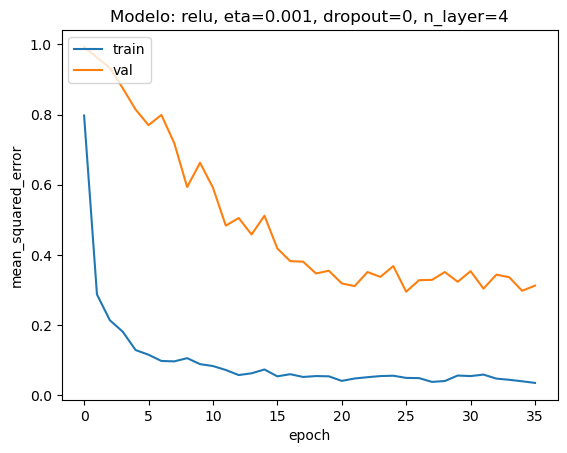

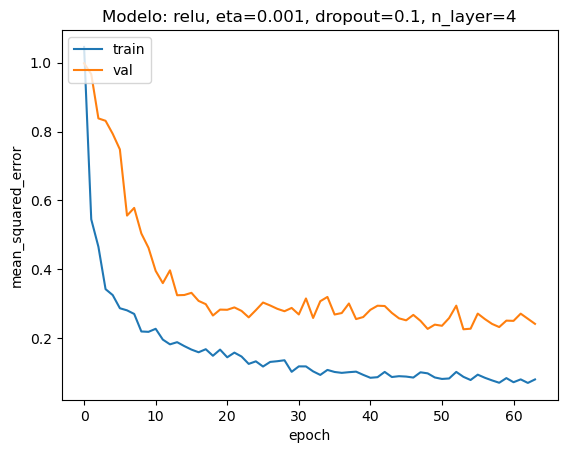

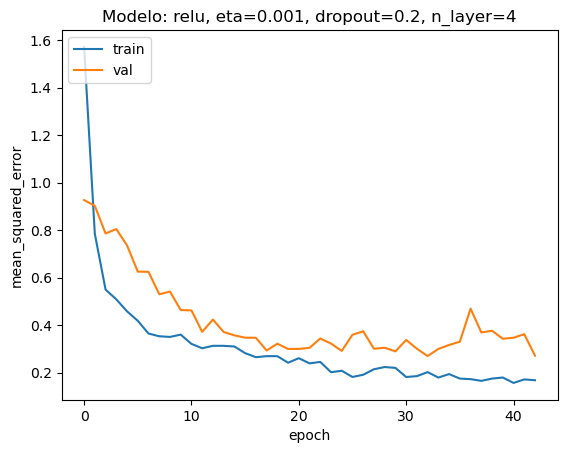

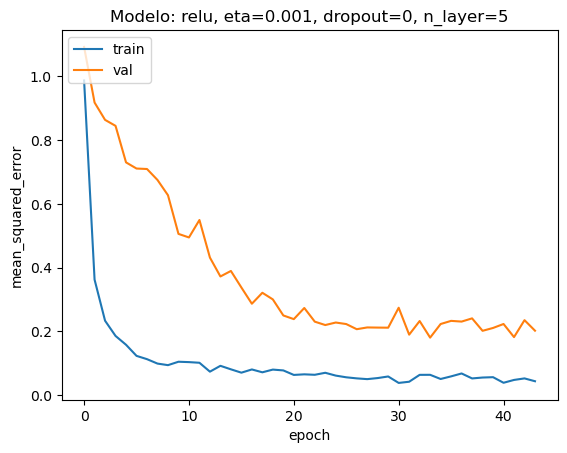

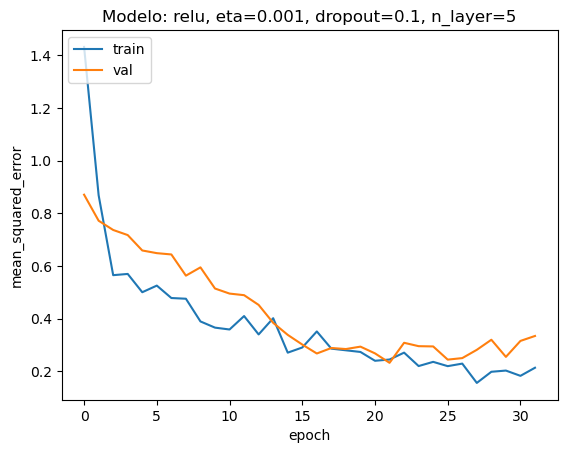

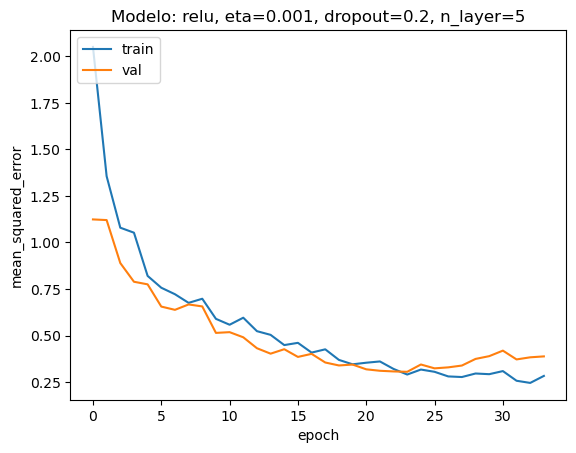

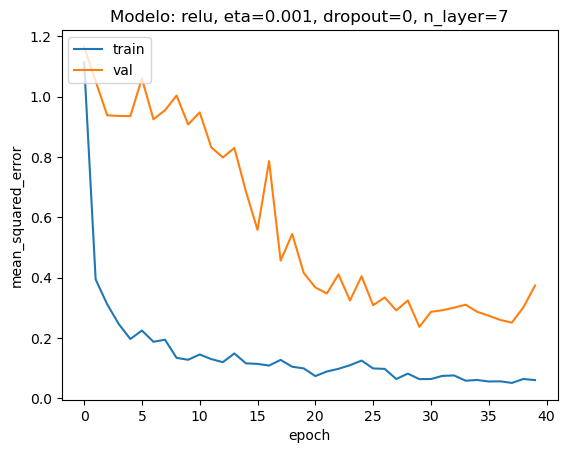

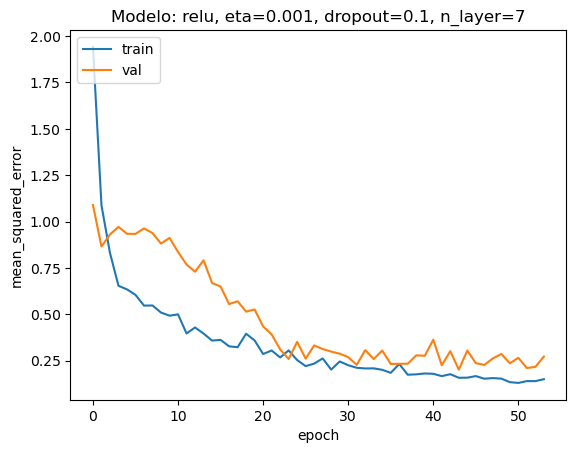

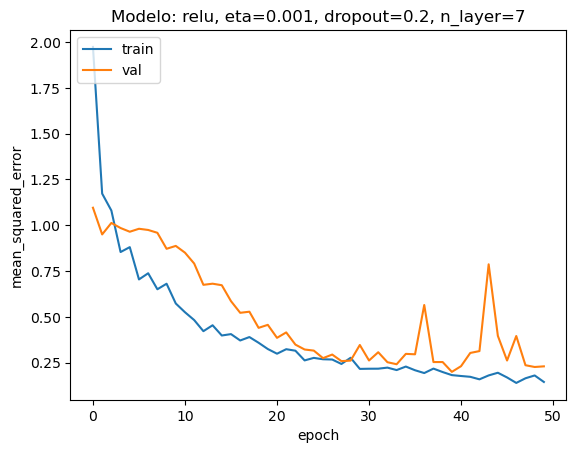

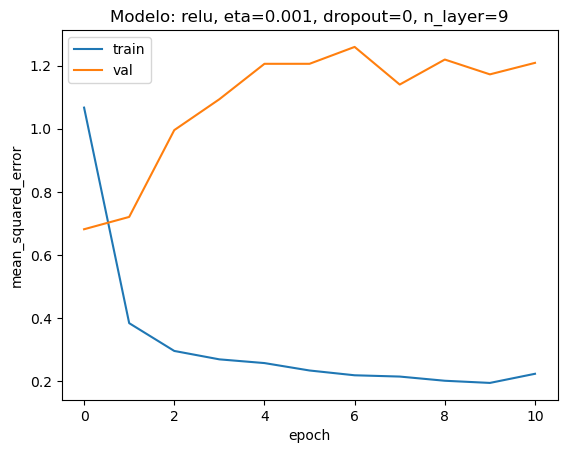

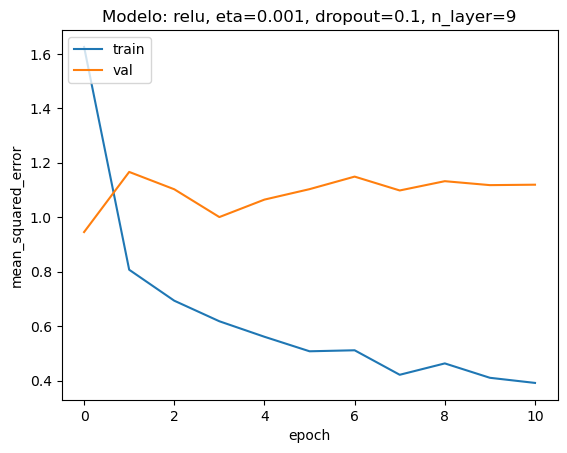

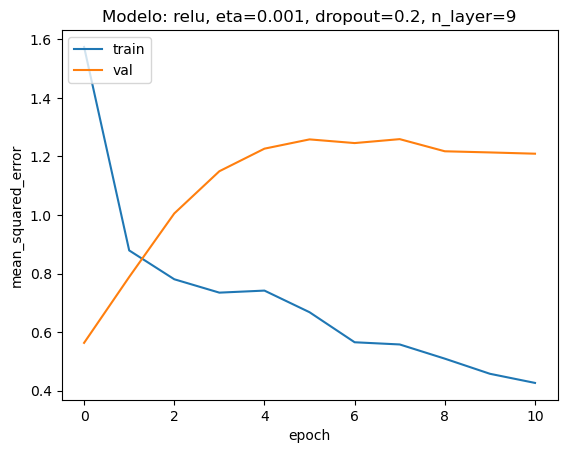

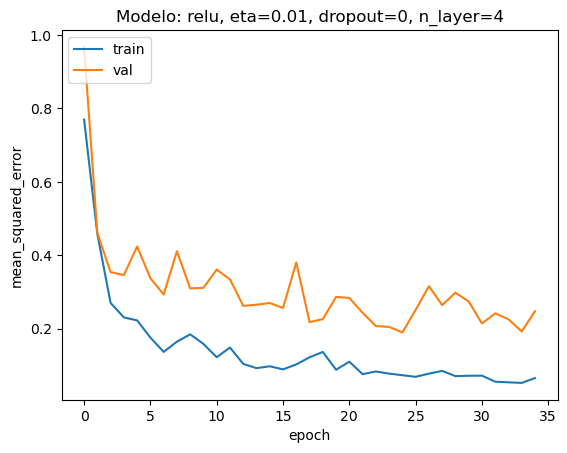

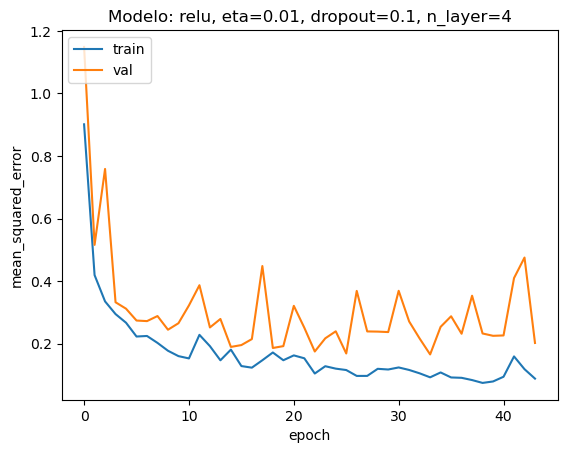

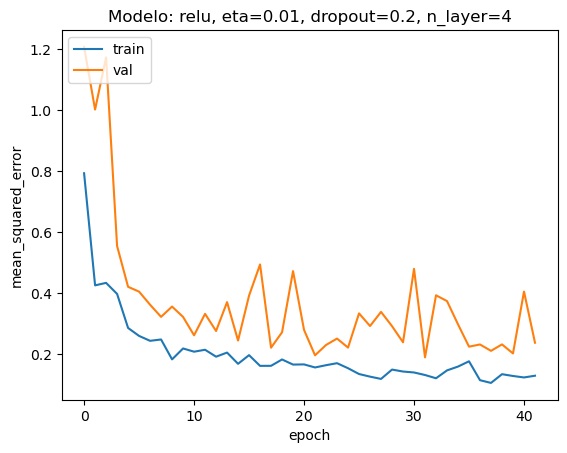

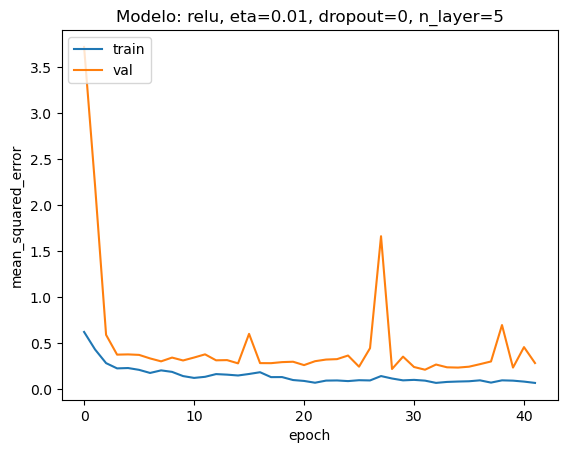

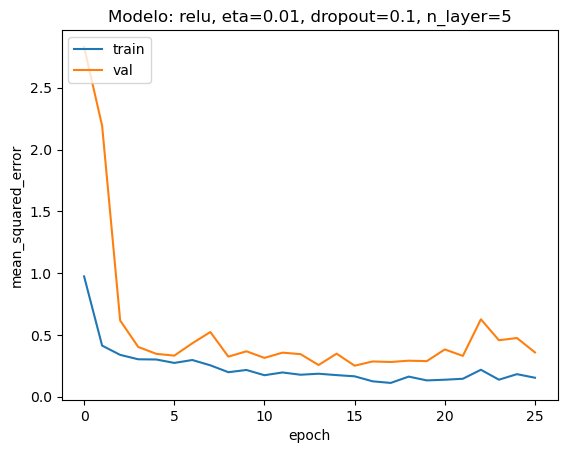

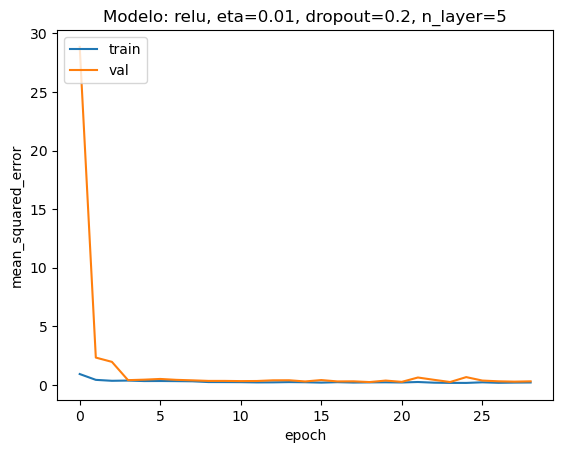

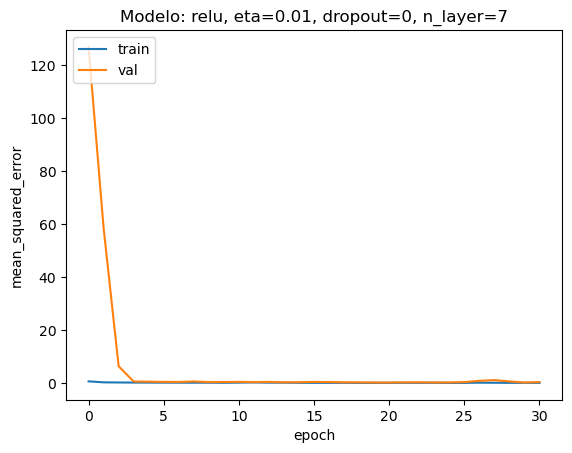

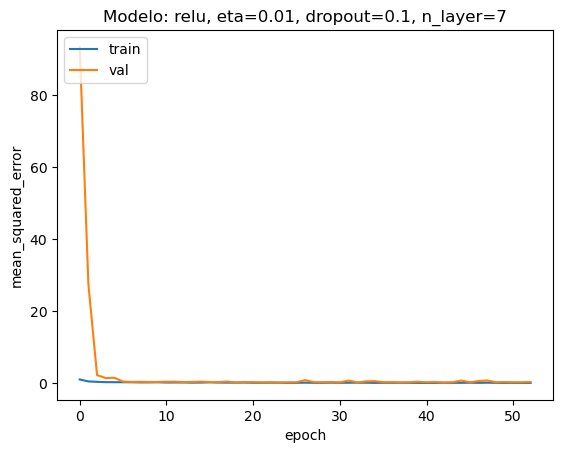

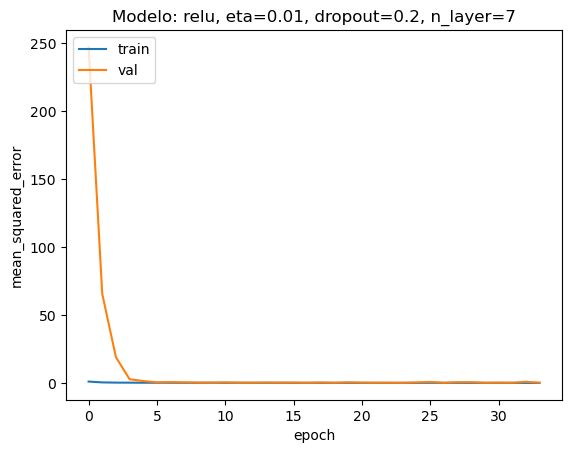

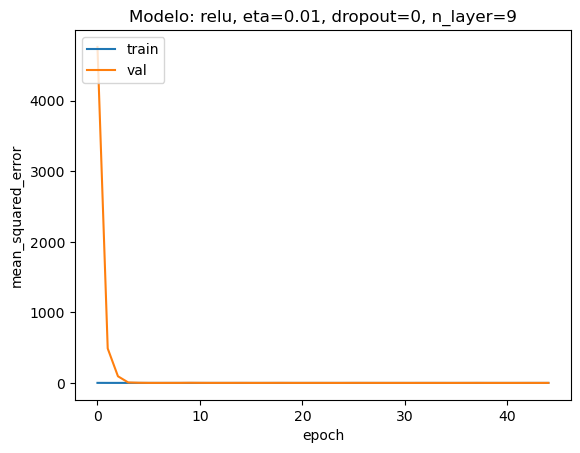

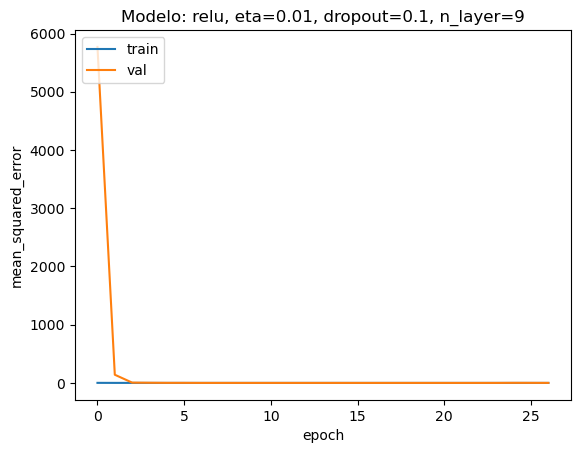

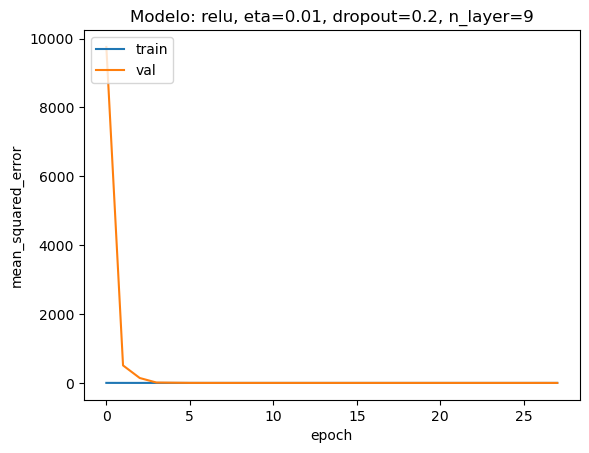

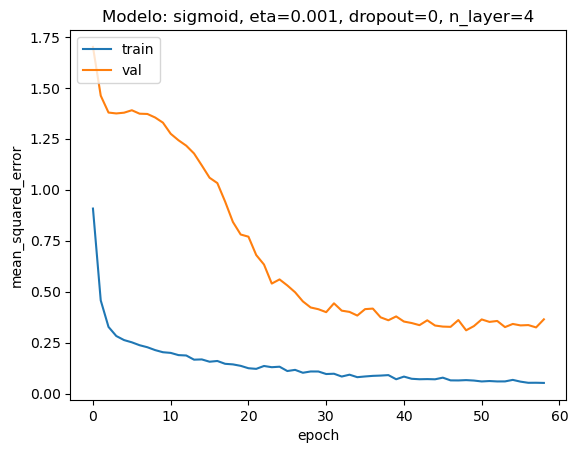

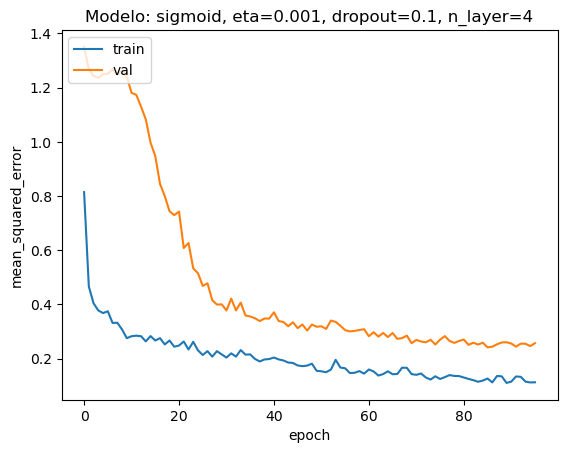

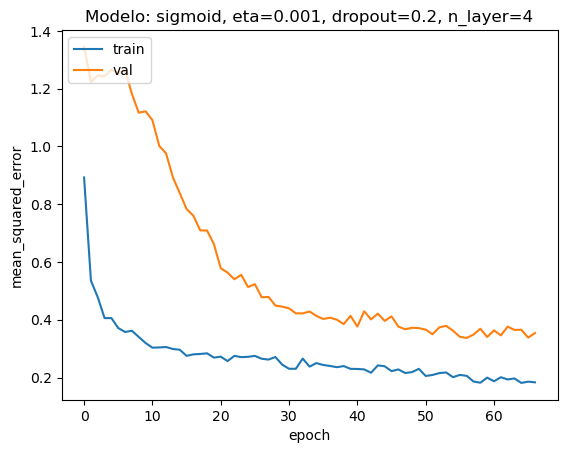

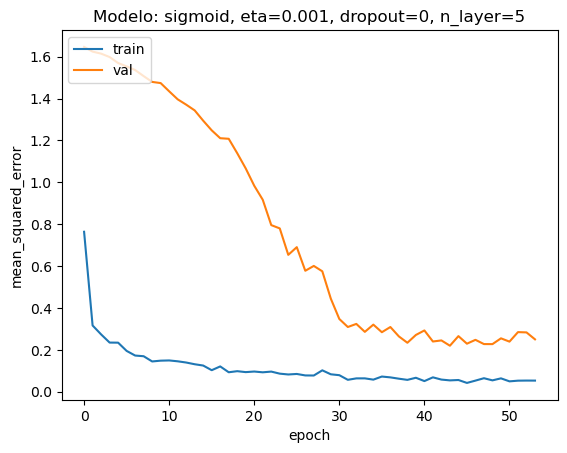

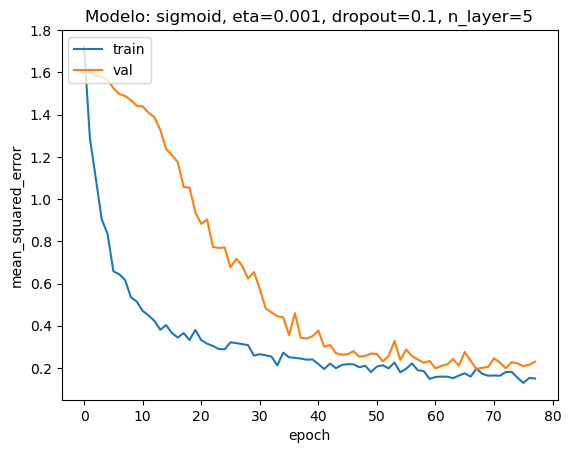

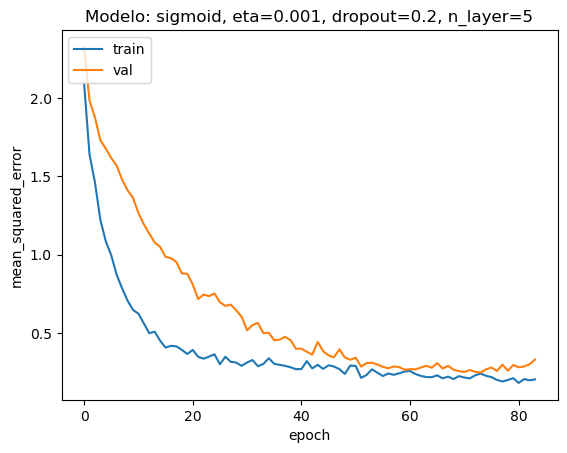

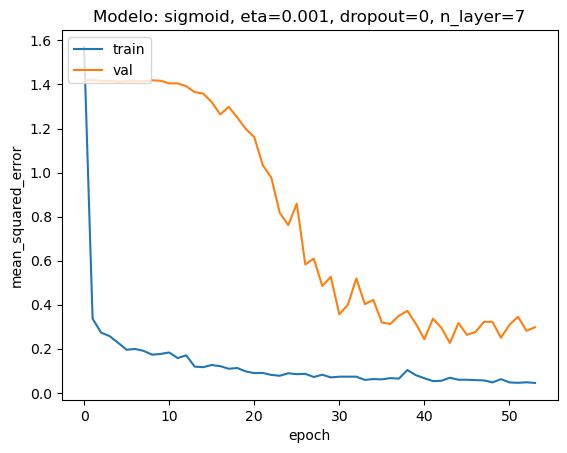

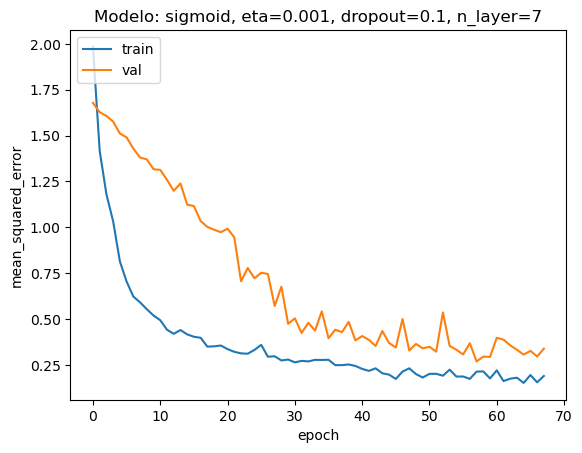

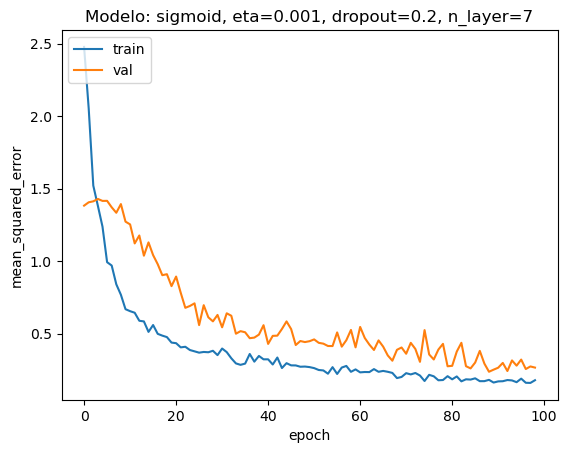

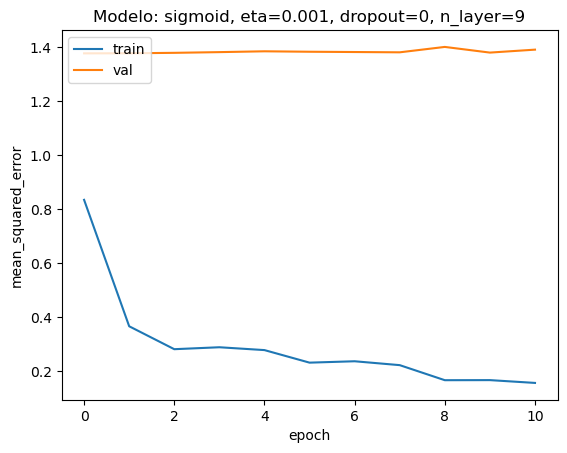

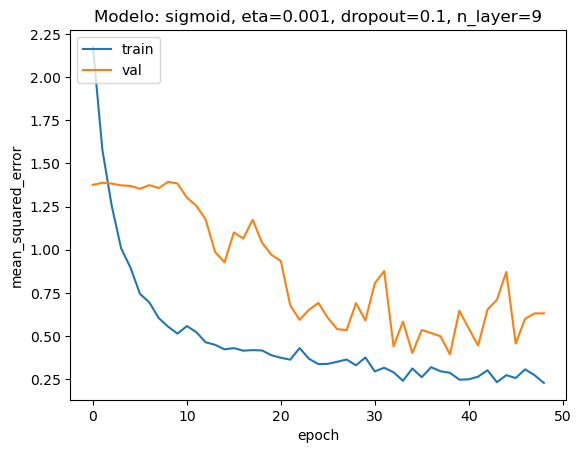

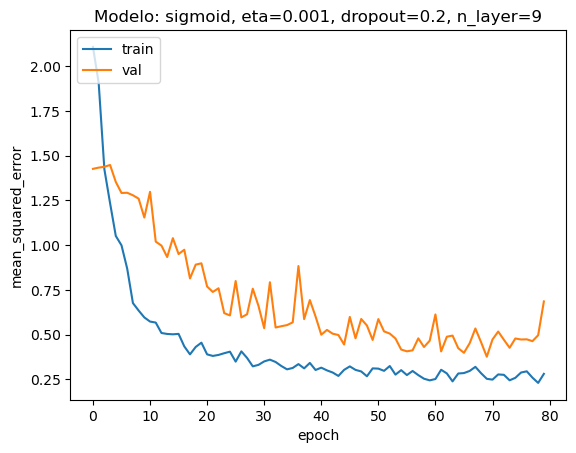

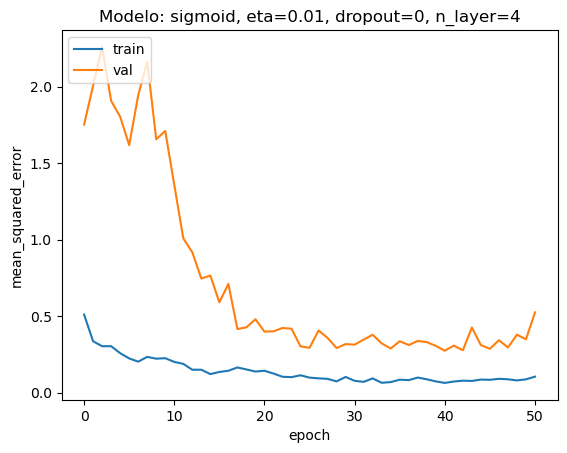

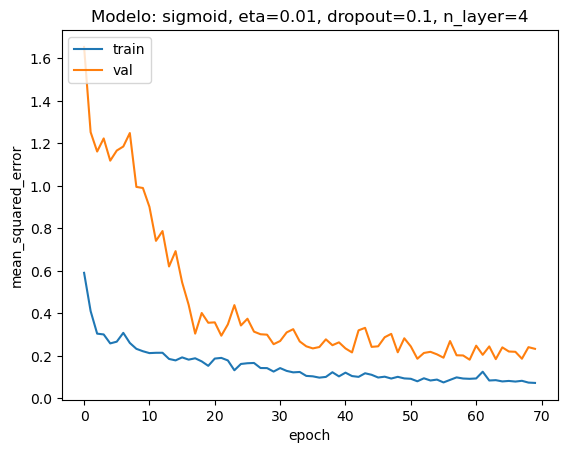

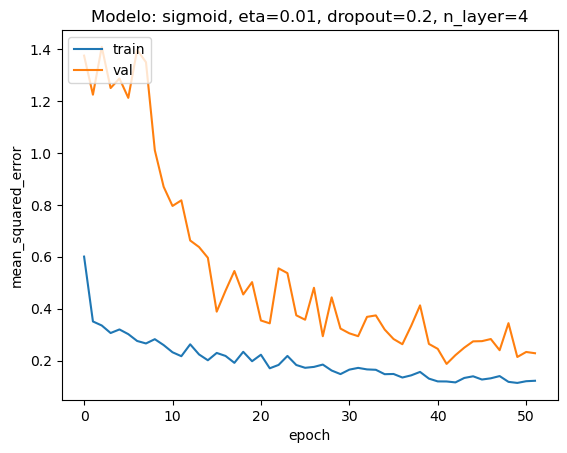

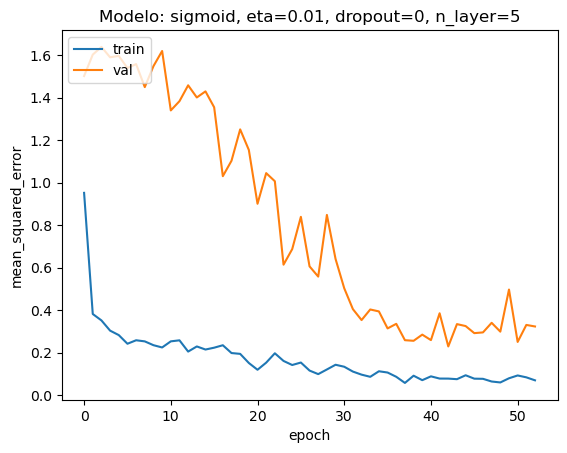

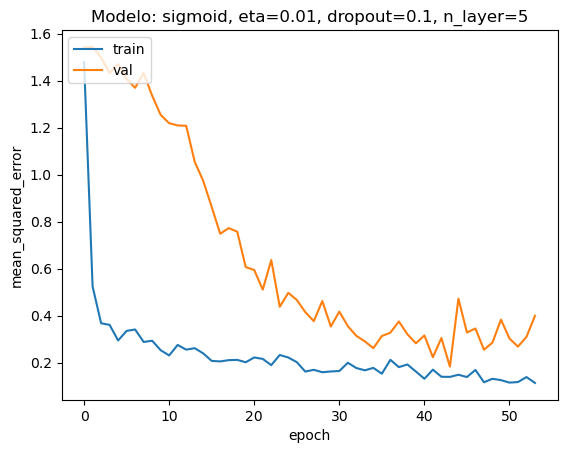

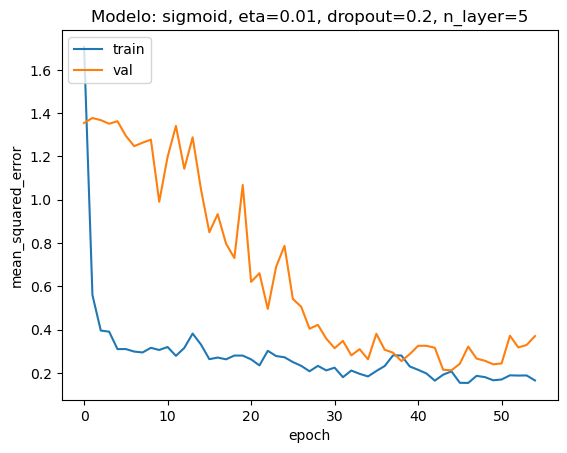

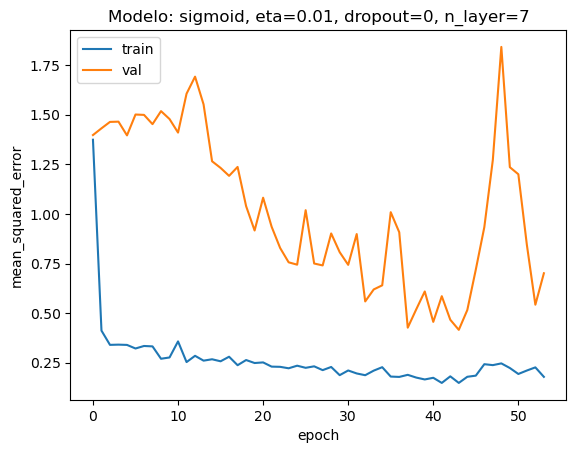

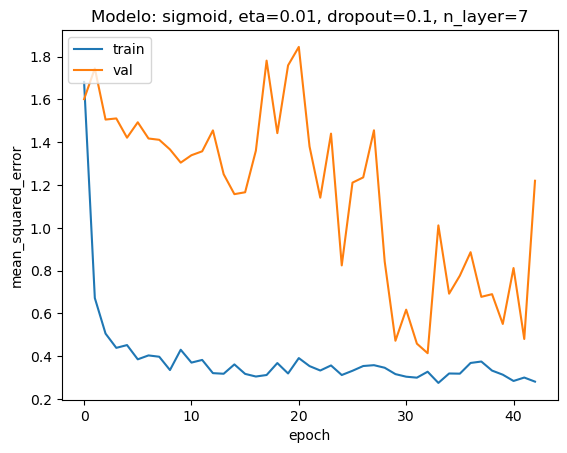

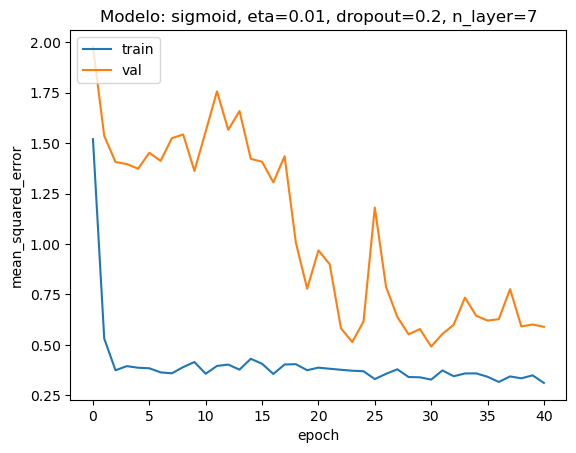

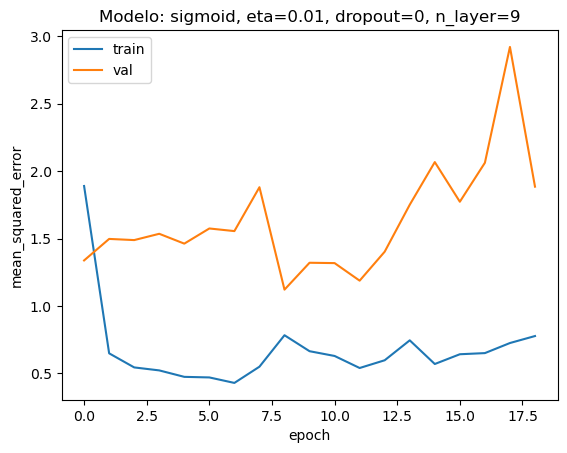

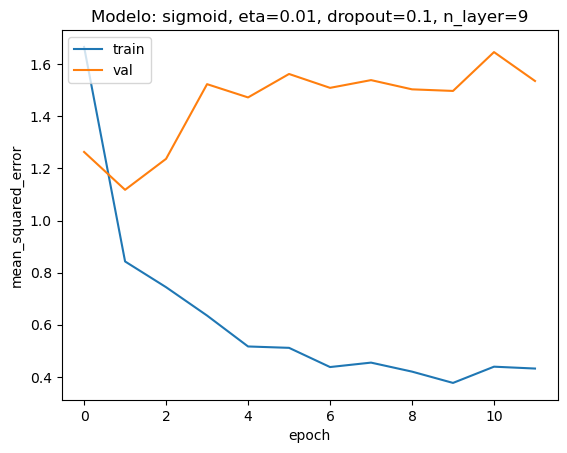

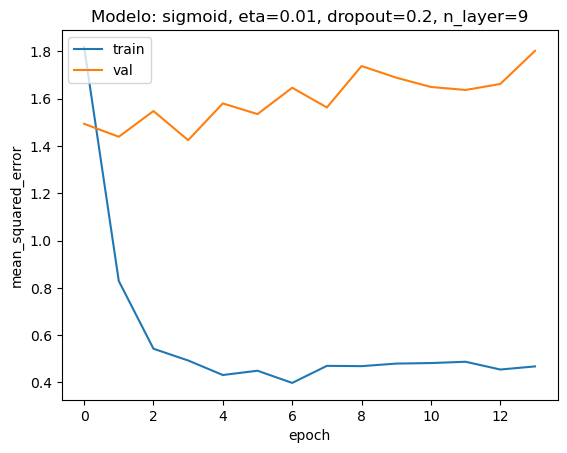

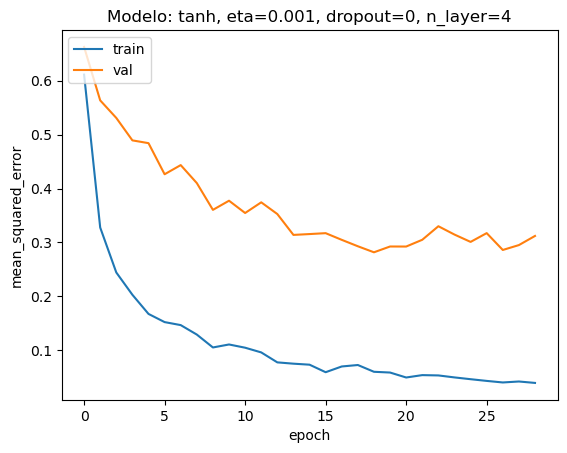

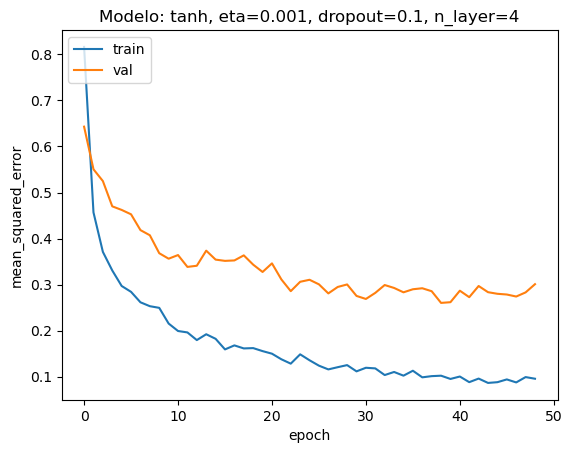

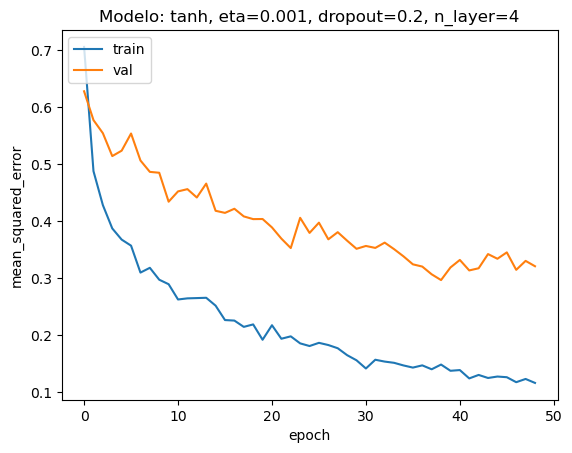

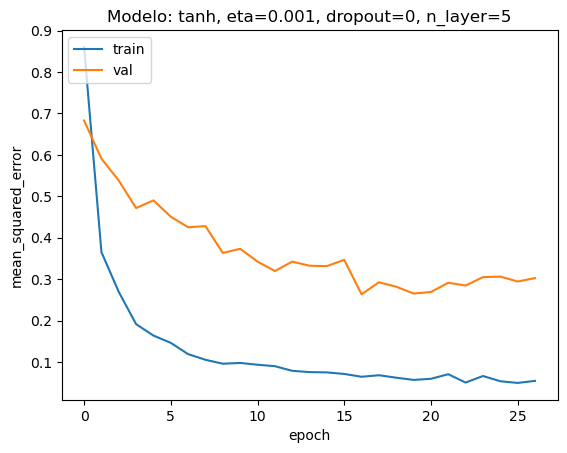

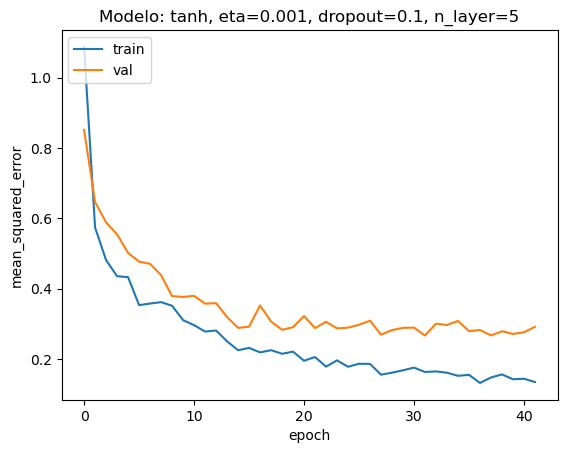

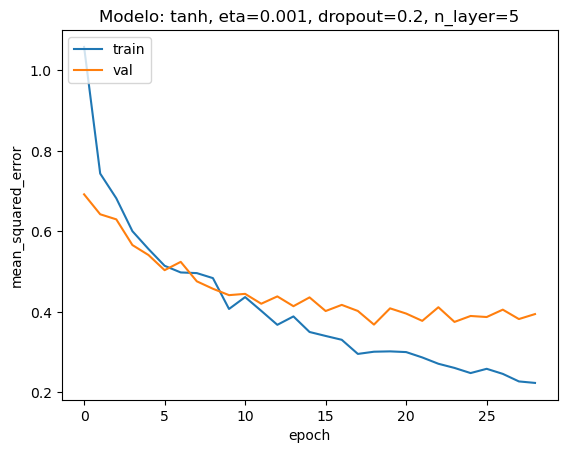

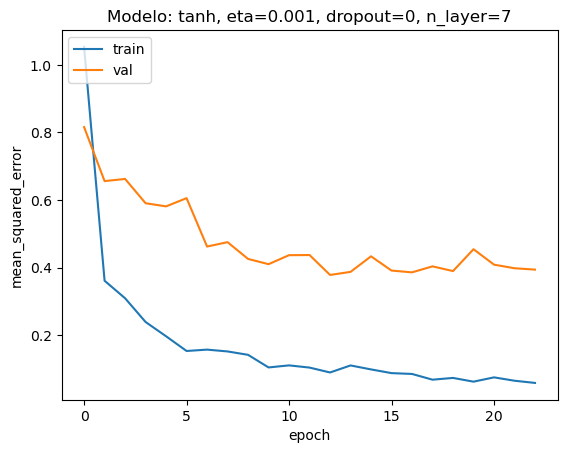

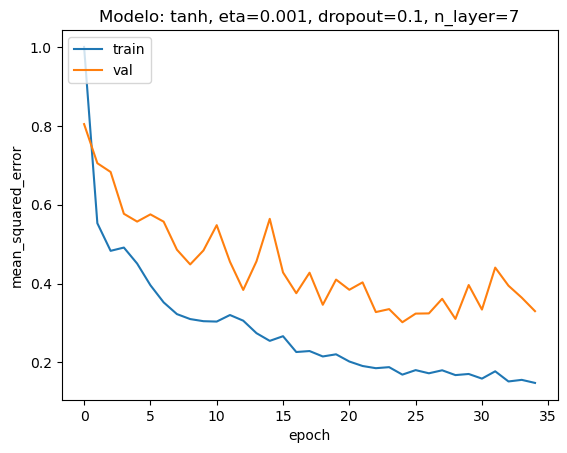

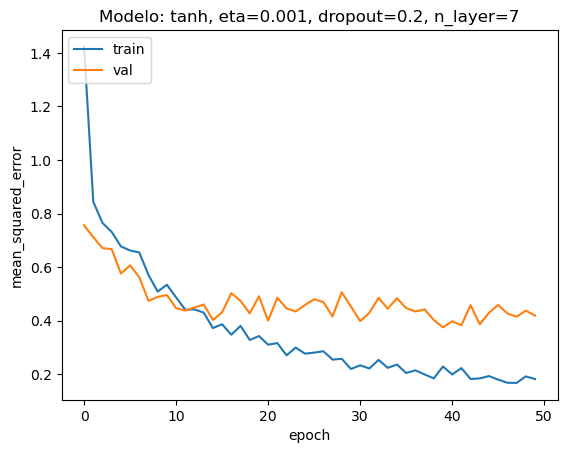

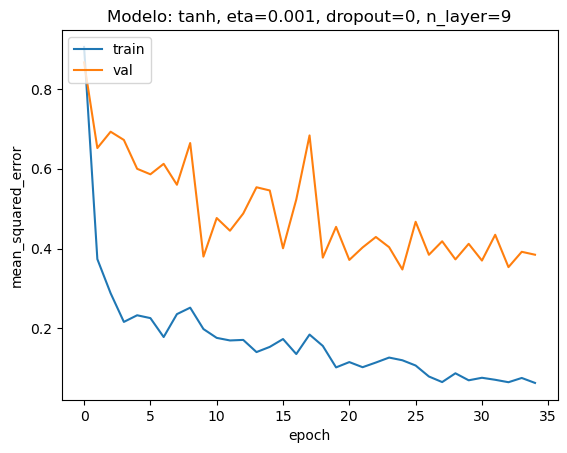

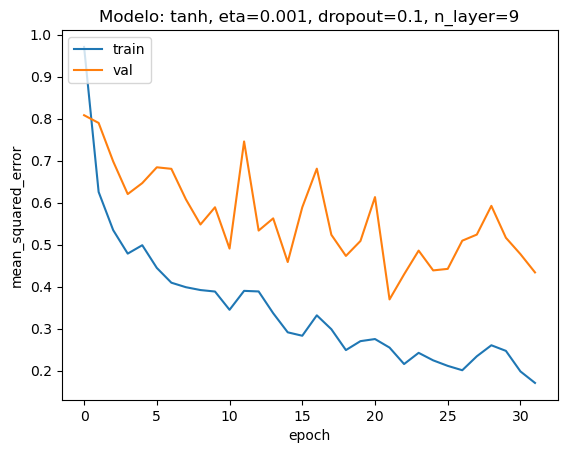

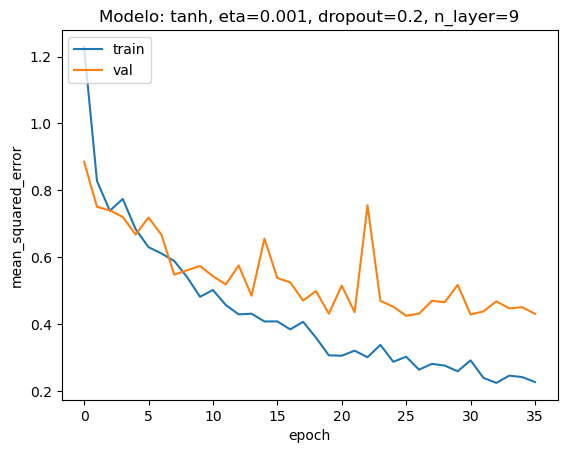

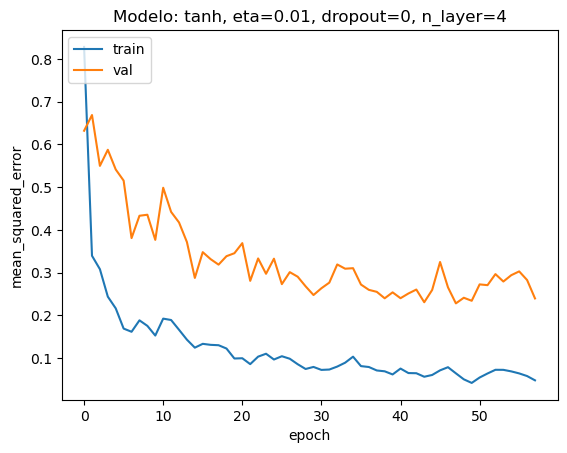

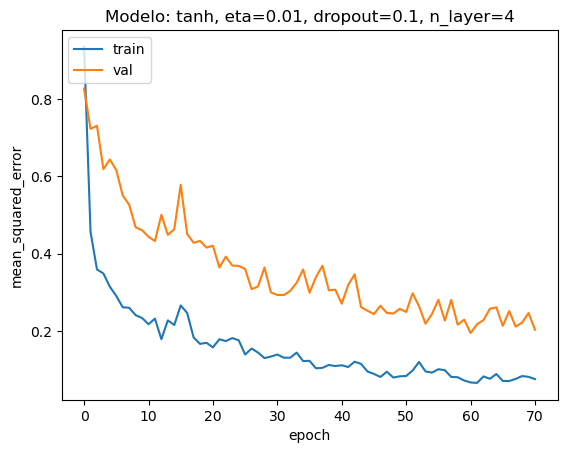

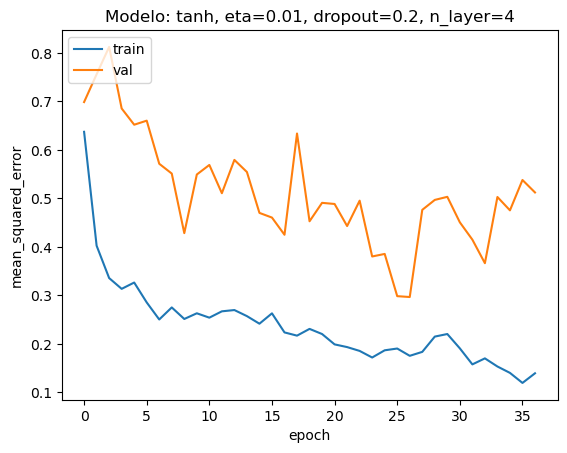

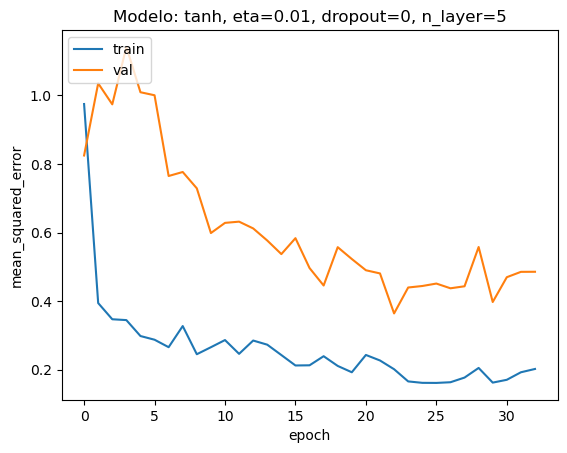

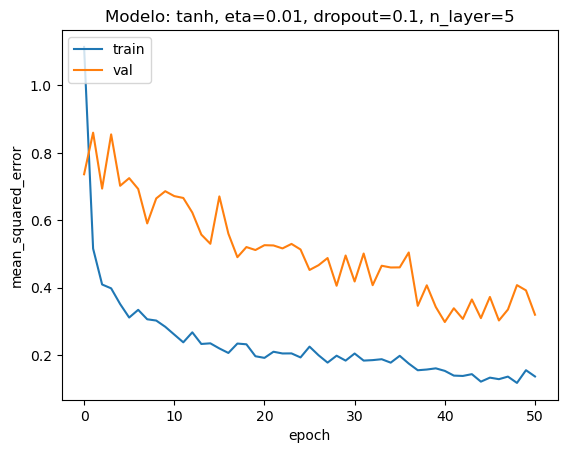

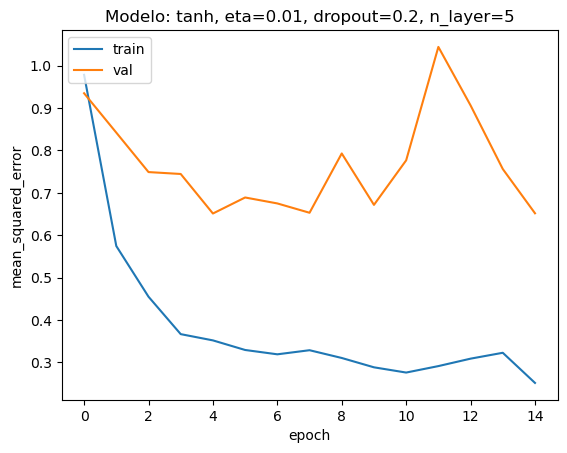

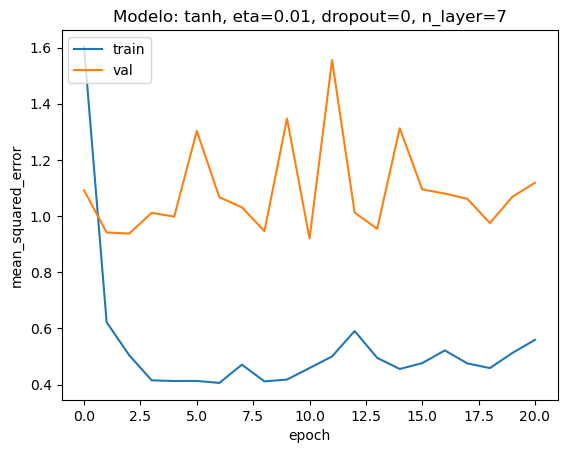

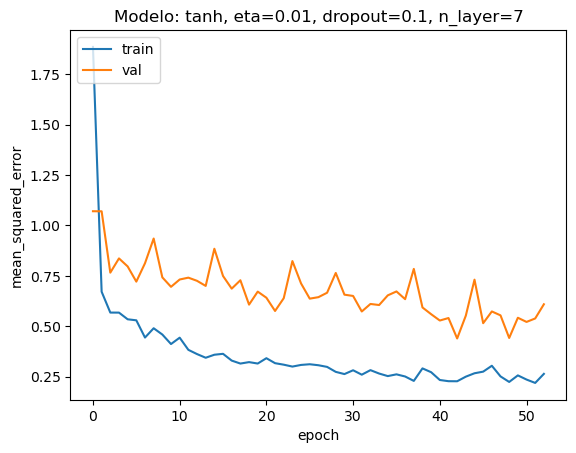

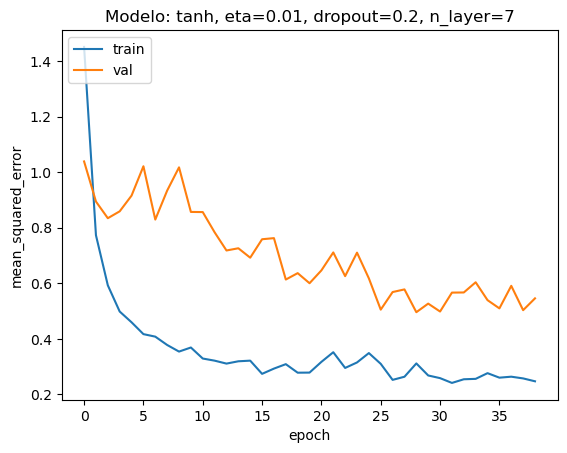

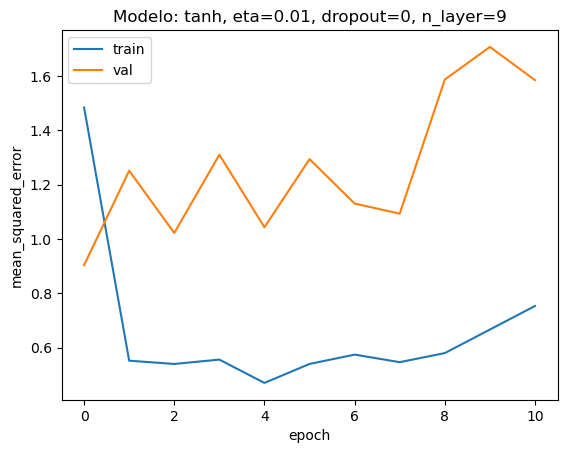

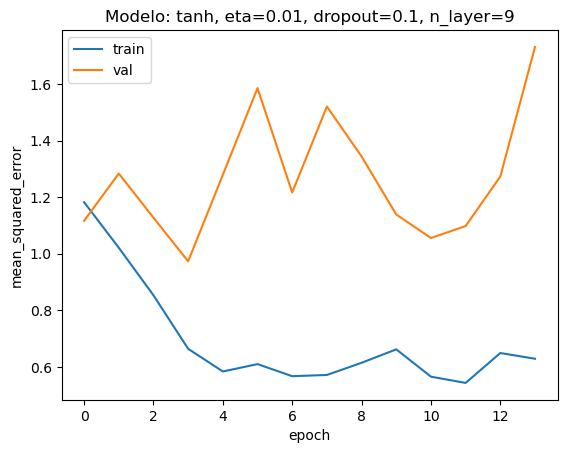

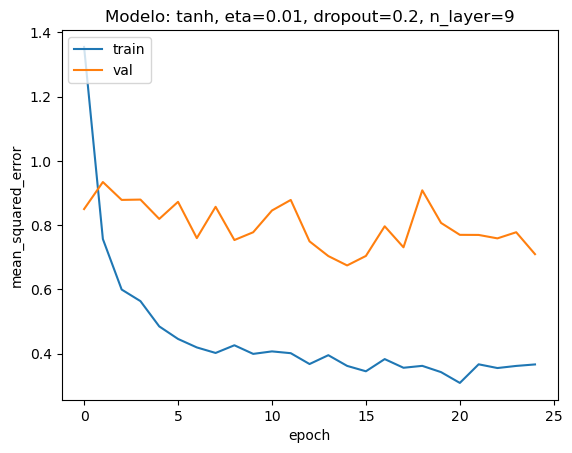

CPU times: user 3h 9min 2s, sys: 1h 16min 48s, total: 4h 25min 50s
Wall time: 1h 23min 53s


In [31]:
%%time
activation_funcs = ['relu', 'sigmoid', 'tanh']
learning_rates = [1e-3, 1e-2]
n_layers = [4,5,7,9]
dropouts = [0, 0.1, 0.2]
i = 0
for activation_func in activation_funcs:
    for eta in learning_rates:
        for n_layer in n_layers:
            for dropout in dropouts:
                model = createmodel(n_layer, activation_func, dropout, eta)
                history = model.fit(X, y, 
                                    epochs=300,
                                    batch_size=128,
                                    validation_split=0.1,
                                    callbacks=my_callbacks,
                                    verbose=0)
                plot_losses(history, keras.losses.MeanSquaredError(), f"Modelo: {activation_func}, {eta=}, {dropout=}, {n_layer=}")
                data[i] = [activation_func, eta, n_layer, dropout, min(history.history['val_loss'])]
                i+=1

In [32]:
data = data.T.sort_values('min_val_loss', ascending = True).reset_index(drop = True)
data

,act_func,learning_rate,n_layers,dropout,min_val_loss
0,relu,0.01,4,0.1,0.165682
1,relu,0.001,5,0,0.180482
2,sigmoid,0.01,4,0.1,0.182245
3,sigmoid,0.01,5,0.1,0.182932
4,sigmoid,0.01,4,0.2,0.187571
...,...,...,...,...,...
67,tanh,0.01,9,0.1,0.972989
68,sigmoid,0.01,9,0.1,1.118081
69,sigmoid,0.01,9,0,1.121225
70,sigmoid,0.001,9,0,1.3764


In [33]:
data.loc[:3]

,act_func,learning_rate,n_layers,dropout,min_val_loss
0,relu,0.01,4,0.1,0.165682
1,relu,0.001,5,0,0.180482
2,sigmoid,0.01,4,0.1,0.182245
3,sigmoid,0.01,5,0.1,0.182932


In [34]:
best_act_func = data.loc[0, 'act_func']
best_eta = data.loc[0, 'learning_rate']
best_dropout = data.loc[0, 'dropout']
best_n_layers = data.loc[0, 'n_layers']

In [35]:
best_model = createmodel(best_n_layers, best_act_func, best_dropout, best_eta)
best_model.summary()

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 24)]              0         
                                                                 
 dense_527 (Dense)           (None, 256)               6400      
                                                                 
 dropout_254 (Dropout)       (None, 256)               0         
                                                                 
 batch_normalization_254 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_528 (Dense)           (None, 128)               32896     
                                                                 
 dense_529 (Dense)           (None, 64)                8256      
                                                          

In [36]:
history = best_model.fit(X, y, 
                         epochs=300,
                         batch_size=64,
                         validation_split=0.1,
                         callbacks=my_callbacks,
                         verbose=2)

Epoch 1/300
18/18 - 2s - loss: 0.8690 - root_mean_squared_error: 0.9322 - val_loss: 0.7537 - val_root_mean_squared_error: 0.8681 - 2s/epoch - 97ms/step
Epoch 2/300
18/18 - 0s - loss: 0.3356 - root_mean_squared_error: 0.5793 - val_loss: 0.6389 - val_root_mean_squared_error: 0.7993 - 98ms/epoch - 5ms/step
Epoch 3/300
18/18 - 0s - loss: 0.2821 - root_mean_squared_error: 0.5311 - val_loss: 0.4015 - val_root_mean_squared_error: 0.6336 - 100ms/epoch - 6ms/step
Epoch 4/300
18/18 - 0s - loss: 0.2849 - root_mean_squared_error: 0.5337 - val_loss: 0.3836 - val_root_mean_squared_error: 0.6193 - 95ms/epoch - 5ms/step
Epoch 5/300
18/18 - 0s - loss: 0.2318 - root_mean_squared_error: 0.4814 - val_loss: 0.3161 - val_root_mean_squared_error: 0.5622 - 106ms/epoch - 6ms/step
Epoch 6/300
18/18 - 0s - loss: 0.2705 - root_mean_squared_error: 0.5201 - val_loss: 0.3693 - val_root_mean_squared_error: 0.6077 - 97ms/epoch - 5ms/step
Epoch 7/300
18/18 - 0s - loss: 0.2115 - root_mean_squared_error: 0.4598 - val_los

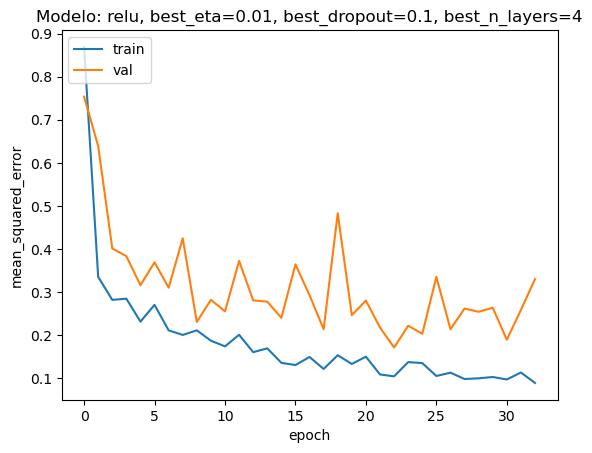

In [37]:
plot_losses(history, keras.losses.MeanSquaredError(), f"Modelo: {best_act_func}, {best_eta=}, {best_dropout=}, {best_n_layers=}")

In [38]:
yy = y_scaler.inverse_transform(y)
y_pred_train = y_scaler.inverse_transform(best_model.predict(X, verbose = 0))

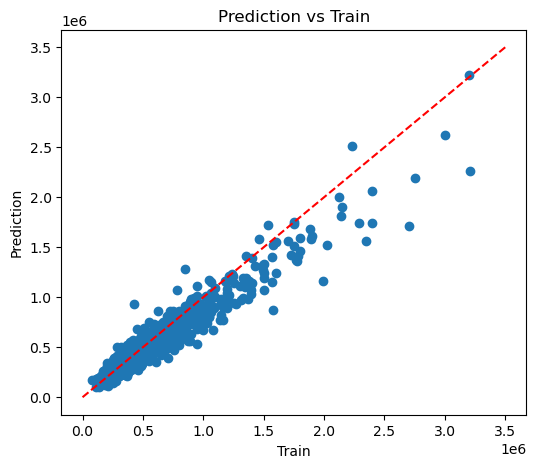

In [39]:
plt.figure(figsize = (6,5))

plt.scatter(yy, y_pred_train)
plt.plot([-2,3.5e6], [-2,3.5e6], '--',  c='red')

plt.xlabel('Train'); plt.ylabel('Prediction')
plt.title('Prediction vs Train');

In [40]:
MSE_train = np.sum((yy-y_pred_train)**2) / len(y)
print(f"{MSE_train = :_.0f}")

MSE_train = 14_169_179_471


In [41]:
prediccion = y_scaler.inverse_transform(best_model.predict(x_test, verbose = 0))
prediccion

array([[1842819.8  ],
       [ 255219.83 ],
       [ 824858.75 ],
       [ 783621.   ],
       [  80665.54 ],
       [ 503134.   ],
       [ 310960.72 ],
       [ 689036.5  ],
       [ 694550.4  ],
       [ 317297.16 ],
       [ 426716.97 ],
       [ 868381.8  ],
       [ 375930.22 ],
       [ 504057.22 ],
       [ 495603.25 ],
       [1031941.2  ],
       [ 428214.03 ],
       [ 273938.38 ],
       [ 355244.2  ],
       [ 588267.9  ],
       [ 581511.06 ],
       [ 438799.03 ],
       [ 422668.56 ],
       [ 169718.92 ],
       [ 505684.56 ],
       [ 447637.12 ],
       [ 326536.6  ],
       [1112445.2  ],
       [ 585534.06 ],
       [ 325550.94 ],
       [ 652960.75 ],
       [ 525898.3  ],
       [ 835768.3  ],
       [ 608297.56 ],
       [ 413953.6  ],
       [ 236670.92 ],
       [ 332592.75 ],
       [ 593030.94 ],
       [ 498121.9  ],
       [ 281584.16 ],
       [ 753461.8  ],
       [ 510037.34 ],
       [ 390686.84 ],
       [ 308122.6  ],
       [ 624409.1  ],
       [ 6

In [42]:
x_test = x_test.reset_index()
x_test['price'] = prediccion
sample_submisssion = x_test[['ID', 'price']]
sample_submisssion

,ID,price
0,1473,1.842820e+06
1,716,2.552198e+05
2,1360,8.248588e+05
3,1522,7.836210e+05
4,1570,8.066554e+04
...,...,...
315,1475,4.424217e+05
316,374,6.125389e+05
317,795,6.067031e+05
318,888,2.045373e+05


In [43]:
sample_submisssion.to_csv('/kaggle/working/sample_submission.csv', index = False)

In [ ]:
#model.save('/kaggle/working/desafio2.keras')